In [118]:
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
import numpy as np
import flax.linen as nn
from typing import Any, List
import dataclasses
import distrax

Array = Any

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
tfd = tfp.distributions
tfb = tfp.bijectors

In [120]:
import sys
sys.path.append("../")

from modules.conditional import ConditionalInverse, ConditionalChain, ConditionalTransformed, ConditionalPermute
from modules.autoregressive import MAF, MADE

In [195]:

class MaskedAutoregressiveFlow(nn.Module):
    n_dim: int
    n_context: int = 0
    n_transforms: int = 4
    hidden_dims: List[int] = dataclasses.field(default_factory=lambda: [32, 32])
    activation: str = "relu"
    unroll_loop: bool = False
    use_random_permutations: bool = True
    rng_key: jnp.ndarray = jax.random.PRNGKey(0)
    inverse: bool = False

    def setup(self):

        self.made = [MADE(n_params=self.n_dim, n_context=self.n_context, activation=self.activation, hidden_dims=self.hidden_dims, name="made_{}".format(i)) for i in range(self.n_transforms)]

        bijectors = []
        key = self.rng_key
        for i in range(self.n_transforms):
            if self.use_random_permutations:
                bijectors.append(ConditionalPermute(jax.random.choice(key, jnp.arange(self.n_dim), shape=(self.n_dim,), replace=False)))
                key, _ = jax.random.split(key)
            else:
                bijectors.append(ConditionalPermute(list(reversed(range(self.n_dim)))))
            bijectors.append(MAF(bijector_fn=self.made[i], unroll_loop=self.unroll_loop))
        
        if self.inverse:
            self.bijector = ConditionalChain(bijectors)
        else:
            self.bijector = ConditionalInverse(ConditionalChain(bijectors))

    def make_flow_model(self):

        flow = self.bijector
        base_dist = distrax.MultivariateNormalDiag(jnp.zeros(self.n_dim), jnp.ones(self.n_dim))
        return flow, base_dist

    def __call__(self, x: jnp.array, z: jnp.array=None) -> jnp.array:
        flow, base_dist = self.make_flow_model()
        return ConditionalTransformed(base_dist, flow).log_prob(x, z)

    def sample(self, num_samples, rng, z: jnp.array=None) -> jnp.array:
        flow, base_dist = self.make_flow_model()
        return ConditionalTransformed(base_dist, flow).sample(seed=rng, sample_shape=(num_samples,), z=z)

In [196]:
maf = MaskedAutoregressiveFlow(n_dim=5, n_context=1, unroll_loop=True)

key = jax.random.PRNGKey(2)
x = jax.random.uniform(key=key, shape=(3, 5))
z = jax.random.uniform(key=key, shape=(3, 1))
params = maf.init(key, x, z)

## Test flow

In [197]:
import optax
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

In [198]:
image = Image.open('../data/iaifi-logo-black-noborder-hires.jpeg').convert('L')
data = np.asarray(image)

In [199]:
dist_true = ~data[::-1]
dist_true = dist_true / np.sum(dist_true)

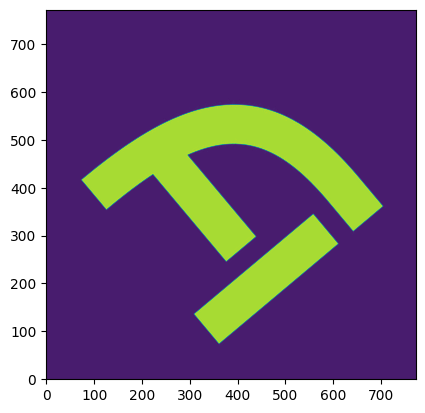

In [200]:
plt.imshow(rotate(dist_true, 50), origin='lower')

In [201]:
pairs = np.indices(dimensions=dist_true.shape).T

n = 5000
inds=np.random.choice(np.arange(np.prod(dist_true.shape)),p=dist_true.reshape(-1),size=n,replace=True)

selections = pairs.reshape(-1,2)[inds].astype(np.float32)
selections_std = selections.std()
selections_mean = selections.mean()


In [202]:
selections = (selections - selections_mean) / selections_std

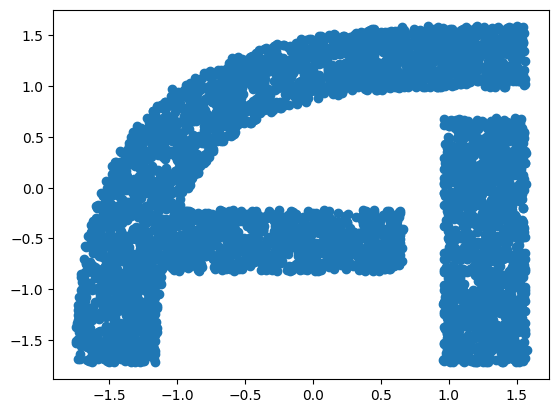

In [203]:
plt.scatter(*selections.T)


In [204]:
def rotate_points(points, angle):
    """Rotate points by angle around origin.
    """
    angle = np.deg2rad(angle)
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.dot(points, rot_matrix)

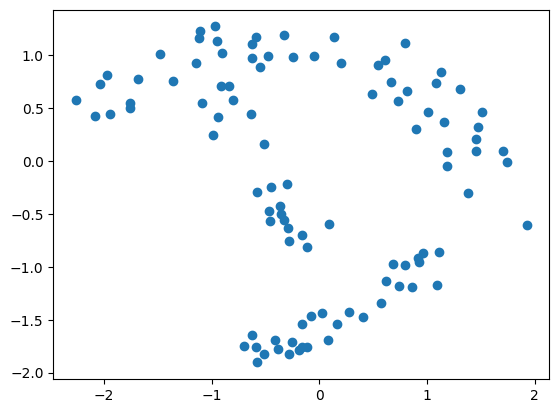

In [205]:
plt.scatter(*rotate_points(selections[:100], 60.).T)

In [242]:
n_dim = 2
model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=1, n_transforms=12, activation="relu", unroll_loop=True, use_random_permutations=False)

key = jax.random.PRNGKey(0)
x = jax.random.uniform(key=key, shape=(8, n_dim))
z = jax.random.uniform(key=key, shape=(8, 1))
params = model.init(key, x, z)

In [243]:
model.apply(params, jnp.array(selections), jnp.ones((selections.shape[0], 1)));

In [244]:
optimizer = optax.adamw(learning_rate=3e-4, weight_decay=1e-5)
opt_state = optimizer.init(params)

@jax.jit
def loss_fn(params, x, z):
  loss = -jnp.mean(model.apply(params, x, z))
  return loss

@jax.jit
def update(params, opt_state, batch):
  x, z = batch
  grads = jax.grad(loss_fn)(params, x, z)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state


In [245]:
from tqdm import tqdm

batch_size = 128
n_steps = 50000

for step in tqdm(range(n_steps)):
    x = selections[np.random.choice(np.arange(len(selections)), size=batch_size, replace=False)]
    rot = np.random.uniform(low=0., high=np.pi)
    x = rotate_points(x, np.rad2deg(rot))
    z = rot * jnp.ones((batch_size, 1))
    batch = x , z
    params, opt_state = update(params, opt_state, batch)


100%|██████████| 50000/50000 [01:33<00:00, 533.39it/s]


(-3.0, 3.0)

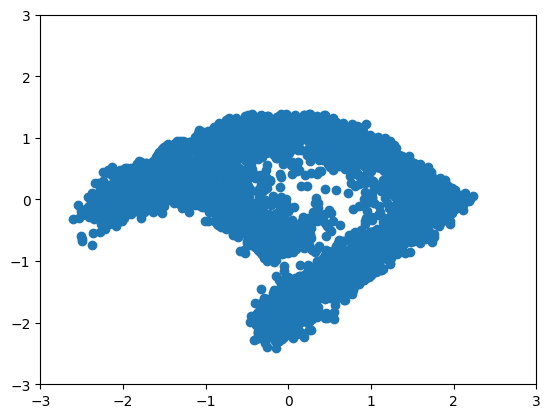

In [248]:
def eval_model(model):
    samples = model.sample(num_samples=5000, rng=key, z=np.deg2rad(45.) * jnp.ones((5000, 1)))
    return samples

samples = nn.apply(eval_model, model)(params)
plt.scatter(*samples.T)
plt.xlim(-3, 3)
plt.ylim(-3, 3)